In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt  
from tqdm import tqdm   
import pandas as pd
import numpy as np
import os, sys, pdb
import torch, torchvision
import pickle
import time
from PIL import Image
# from pykeops.torch import LazyTensor

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import models, datasets
from utils import *

### Plot AUC Curve

In [ ]:
from sklearn import metrics

df_tube = pd.read_csv('xxx')
df_notube = pd.read_csv('xxx')
df_all = pd.read_csv('xxx')
class_name = 'Pneumothorax' # column name as per the outcomes.csv file

class_prob = class_name + '_prob'
fpr_tube, tpr_tube, thresholds1 = metrics.roc_curve(df_tube[class_name], df_tube[class_prob])
fpr_notube, tpr_notube, thresholds2 = metrics.roc_curve(df_notube[class_name], df_notube[class_prob])
fpr, tpr, thresholds = metrics.roc_curve(df_all[class_name], df_all[class_prob])
auc_tube = metrics.auc(fpr_tube,tpr_tube)
auc_notube = metrics.auc(fpr_notube,tpr_notube)
auc = metrics.auc(fpr,tpr)

plt.plot(fpr,tpr,label='All (AUC %.2f)'%(auc))
plt.plot(fpr_tube,tpr_tube,label='Chest Drains (AUC %.2f)'%(auc_tube))
plt.plot(fpr_notube,tpr_notube,label='No Chest Drains (AUC %.2f)'%(auc_notube))


plt.title('%s Detection' %(class_name))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [ ]:
df_tube[' pneumothorax']

### Analyse Correlations

In [ ]:
def analyse_correlations(df, disease, shortcut):
    
    a = len(df[(df[disease]==1)&(df[shortcut]==0)])
    b = len(df[(df[disease]==1)&(df[shortcut]==1)])
    c = len(df[(df[disease]==0)&(df[shortcut]==0)])
    d = len(df[(df[disease]==0)&(df[shortcut]==1)])

    ax= plt.subplot()
    sns.heatmap([[a,b],[c,d]], annot=True, fmt='g', ax=ax, cmap='coolwarm')  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel(shortcut);ax.set_ylabel(disease)
    ax.set_title('Correlation Analysis')
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()

In [ ]:
df = pd.read_csv('xxx')

list1 = ['effusion', 'opacity', 'pneumothorax',
       'edema', 'atelectasis', 'consolidation', 'pneumonia',
       'congestion', 'cardiomegaly', 'fracture', 'device',
       'emphysema', 'mass', 'hernia', 'lesion']

# list2 = ['normal', 'clear', 'sharp', 'sharply', 'unremarkable',
#        'intact', 'stable', 'free', 'tube', 'process',
#        'abnormality', 'enlarge', 'tip', 'low', 'line',
#        'catheter', 'air', 'tortuous',
#        'lead', 'disease', 'calcification', 'prominence', 
#        'engorgement', 'picc', 'clip', 'elevation', 'expand', 'nodule', 'wire',
#        'fluid', 'degenerative', 'pacemaker', 'thicken', 'marking', 'scar',
#        'hyperinflate', 'blunt', 'loss', 'widen', 'collapse', 'density',
#        'aerate', 'crowd', 'infiltrate', 'obscure',
#        'deformity', 'drainage', 'distention', 'shift', 'stent',
#        'pressure', 'finding', 'borderline', 'hardware', 'dilation',
#        'chf', 'redistribution', 'aspiration', 'tail_abnorm_obs',
#        'excluded_obs']

list2 = ['tube', 'tip', 'low', 'line', 'catheter', 'nodule', 'wire',
       'pacemaker', 'marking', 'scar','drainage', 'stent',
       'hardware']

for disease in tqdm(list1):
    for shortcut in tqdm(list2):
        analyse_correlations(df, disease, shortcut)

### Visualize images in dataset

In [ ]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, preds=None, labels=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        elsek:
            img = img_list[i]
        plt.imshow(img)
        if preds is not None:
            if preds[i]==labels[i]:
                plt.title('pred:%d, label:%d' %(preds[i],labels[i]), fontdict={'color':'g','fontsize':15})
            else:
                plt.title('pred:%d, label:%d' %(preds[i],labels[i]), fontdict={'color':'r','fontsize':15})
    plt.show()

# search for images in the dataset with the given conditions
def viz_dataset(df, conditions=None, path_col='path', rows=3, cols=3):
    if conditions is not None:
        bool_arr = (df[conditions[0]['name']]==conditions[0]['value'])
        for cond in conditions[1:]:
            bool_arr = (bool_arr) & (df[cond['name']]==cond['value'])
        df = df[bool_arr]
    df = df.sample(frac=1)
    plot_images(list(df.head(rows*cols)[path_col]),rows,cols)

def viz_cam_maps(model, loader, rows, cols):
    for batch in loader:
        imgs = batch['img'].to('cuda')
        labels = batch['lab'].squeeze().cpu().numpy()
        targets = [ClassifierOutputTarget(0)]*len(imgs)
        target_layers = [model.features[-1]]

        # get model predictions
        model = model.to('cuda')
        preds = model(imgs)
        preds = (preds>0).squeeze().cpu().numpy().astype(float)

        # fetch Class Activation Maps (cams)
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cams = cam(input_tensor=imgs, targets=targets, aug_smooth=True, eigen_smooth=True)
        
        # overlay cam on original images
        imgs = imgs.squeeze().unsqueeze(-1).detach().cpu().numpy()
        img_list = []   # list of ndarray imgs
        for i in range(rows*cols):
            cam_op = show_cam_on_image(imgs[i]*250, grayscale_cams[i]*0.5, use_rgb=True)
            img_list.append(cam_op)

        # plot overlays
        plot_images(img_list,rows,cols,preds,labels)
        break


class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)



In [ ]:
# GRAD-CAM PLOTS

# user hyperparams
ckpt_path = 'xxx'
data_file = 'xxx'
class_names = ['pneumothorax']
rows = 16
cols = 4


model = torch.load(ckpt_path)

transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])
dataset = datasets.MIMIC_Dataset(csvpath=data_file, class_names=class_names, transform=transforms, seed=0)
loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=rows*cols,
                                    shuffle=True,
                                    num_workers=4, 
                                    pin_memory=True)

viz_cam_maps(model.to('cuda'), loader, rows, cols)

In [ ]:
df = pd.read_csv('xxx')
viz_dataset(df, [{'name':'pneumothorax','value':1},{'name':'tube','value':1}])

In [ ]:
df = pd.read_csv('xxx')
viz_dataset(df,rows=9,cols=3)

### Obtain Hidden Stratifications (csv files)

In [ ]:
df_test = pd.read_csv('xxx')
bool_tubes = (df_test['catheter']==1) | (df_test['tube']==1) | (df_test['drainage']==1)
bool_disease = (df_test['pneumothorax']==1)
# bool_ = (df_test['pacemaker']==1) & (df_test['wire']==1) & (df_test['catheter']==1)
df_pos_tube = df_test[bool_disease & bool_tubes]
df_pos_notube = df_test[bool_disease & ~bool_tubes]
df_neg_tube = df_test[~bool_disease & bool_tubes]
df_neg_notube = df_test[~bool_disease & ~bool_tubes]

df_all_tubes = pd.concat([df_pos_tube,df_neg_tube])
df_no_tubes = pd.concat([df_pos_notube,df_neg_notube])
df_pos_tubes = pd.concat([df_pos_tube,df_neg_notube])
df_neg_tubes = pd.concat([df_pos_notube,df_neg_tube])

In [ ]:
# viz_dataset(df, [{'name':'pneumothorax','value':1},{'name':'catheter','value':0},{'name':'tube','value':0},{'name':'drainage','value':0},{'name':'pacemaker','value':0},{'name':'wire','value':0},{'name':'line','value':0},{'name':'tip','value':0}])

### RadGraph annotations (for various tubes, catheters)
We are looking for tubes and catheters that are OBS-DP and their modifiers denote the type of tube or catheter.
Specific tubes 

In [ ]:
# find all images with tubes and catheters and get their types

In [ ]:
df_final = pd.merge(df,df,how='left',left_on=['target','subject_id','study_id'],right_on=['source','subject_id','study_id'])

In [ ]:
df_final.head(5)

In [ ]:
df_final[(df_final['relation_x']=='located_at')&(df_final['token_x']=='catheter')][['subject_id','study_id','token_x','relation_x','token_y','label_x']].to_csv('temp.csv',index=False)

In [ ]:
# find unique tubes and cathters along with their counts

In [ ]:
df_temp = pd.DataFrame()
names = np.unique(df_caths['token_y'],return_counts=True)[0]
counts = np.unique(df_caths['token_y'],return_counts=True)[1]
df_temp['cath_location'] = names
df_temp['count'] = counts

In [ ]:
df_temp.to_csv('./mimic_unique_caths_located_at(temp).csv',index=False)

In [ ]:
'''
we are interested in the following:
pigtail (catheter)
pleural (tube/catheter)
chest (tube)
thoracostomy (tube)

find specific tubes/catheters and their image locations
we are basically interested in tubes and catheters that are OBS-DP
and types we are interested in:
pigtail catheter, pleural/pleurX/pleurex tube/catheter, chest tube, thoracostomy tube
the relationship is different for each
for eg., "pigtail" modifies "cathter", whereas "tube" is located at "pleural"
some tokens can have both "modify" and "located at" relationships, like "chest tube"
"tube" is located at "chest" and "chest" modifies "tube" both kinds of data were found in the report!
'''


In [ ]:
df_caths = df_caths[df_caths['label_x']=='OBS-DP'].loc[df_caths['token_y'].str.contains('pleur',case=False)]
df_caths

In [ ]:
df_caths = df_caths[['subject_id','study_id']].drop_duplicates()
df_caths


In [ ]:
df_caths = pd.merge(df_caths, df_all,  how='inner', left_on=['subject_id','study_id'], right_on=['patient_id','study_id'])
df_caths

In [ ]:
df_caths.to_csv('./temp_df_pleural_caths.csv',index=False)

### Create Shortcut and Groups

In [10]:
# either df or path should be provided. path overrides df
# provide split info if you're only interested in subset of data
def create_shortcut(spurious_corr, df=None, path=None, split_info=None, skew=1.0):
    
    if path is not None:
        df = pd.read_csv(path)
    
    if split_info is not None:
        col = split_info['col_name']
        values = split_info['values']
        arr = [False]*len(df)
        for val in values:
            arr = ( arr | (df[col]==val) )
        df = df[arr]
        
    bool_arr = {}
    bool_arr['core'] = []
    bool_arr['spurious'] = []
    for key in spurious_corr:
        if len(spurious_corr[key])==2:
            flag = 'range' # it's a continuous variable, apply <,>=
        elif len(spurious_corr[key])==3:
            flag = 'hard' # it's a discrete assignment, apply ==
        else:
            raise('Invalid "spurious_corr" dictionary')
            
        if flag=='range':
            attr = spurious_corr[key][0]
            thresh = spurious_corr[key][1]
            
            arr_temp = (df[attr]<thresh)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df[attr]>=thresh)
            bool_arr[key].append(arr_temp)
        elif flag=='hard':
            attr = spurious_corr[key][0]
            thresh1 = spurious_corr[key][1]
            thresh2 = spurious_corr[key][2]
            
            arr_temp = (df[attr]==thresh1)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df[attr]==thresh2)
            bool_arr[key].append(arr_temp)
        else:
            raise('Invalid flag variable')
            
    # all diagonal elements must be present in most cases
    arr00 = ((bool_arr['core'][0])&(bool_arr['spurious'][0]))
    arr11 = ((bool_arr['core'][1])&(bool_arr['spurious'][1]))
    arr01 = ((bool_arr['core'][0])&(bool_arr['spurious'][1]))
    arr10 = ((bool_arr['core'][1])&(bool_arr['spurious'][0]))
    
    df00 = df[arr00]
    df11 = df[arr11]
    df01 = df[arr01]
    df10 = df[arr10]
    df_diag = pd.concat([df00,df11]).sample(frac=1)
    df_nondiag = pd.DataFrame()
    if skew == 1.0:
        df_final = df_diag
    else:
        coeff = (1/skew-1)
        num_nondiag = int(len(df_diag)*coeff) # number of non-diag samples needed
                                                # to satisfy skew requirement
        df_nondiag = pd.concat([df10,df01]).sample(frac=1)
        if len(df_nondiag)>=num_nondiag: # meaning you have required num of samples
            df_nondiag = df_nondiag.sample(n=num_nondiag)
        else:
            # reduce number of diag samples to fulfill ratio
            num_diag = int(len(df_nondiag)/coeff)
            df_diag = df_diag.sample(n=num_diag)
            
        df_final = pd.concat([df_diag,df_nondiag]).sample(frac=1)    
        
    # get group stats
    bool_arr = {}
    bool_arr['core'] = []
    bool_arr['spurious'] = []
    for key in spurious_corr:
        if len(spurious_corr[key])==2:
            flag = 'range' # it's a continuous variable, apply <,>=
        elif len(spurious_corr[key])==3:
            flag = 'hard' # it's a discrete assignment, apply =
        else:
            raise('Invalid "spurious_corr" dictionary')
            
        if flag=='range':
            attr = spurious_corr[key][0]
            thresh = spurious_corr[key][1]
            
            arr_temp = (df_final[attr]<thresh)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df_final[attr]>=thresh)
            bool_arr[key].append(arr_temp)
        elif flag=='hard':
            attr = spurious_corr[key][0]
            thresh1 = spurious_corr[key][1]
            thresh2 = spurious_corr[key][2]
            
            arr_temp = (df_final[attr]==thresh1)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df_final[attr]==thresh2)
            bool_arr[key].append(arr_temp)
        else:
            raise('Invalid flag variable')

    arr00 = ((bool_arr['core'][0])&(bool_arr['spurious'][0]))
    arr11 = ((bool_arr['core'][1])&(bool_arr['spurious'][1]))
    arr01 = ((bool_arr['core'][0])&(bool_arr['spurious'][1]))
    arr10 = ((bool_arr['core'][1])&(bool_arr['spurious'][0]))
    
    df00 = df_final[arr00]
    df11 = df_final[arr11]
    df01 = df_final[arr01]
    df10 = df_final[arr10]
    
    group_dfs = {'df_c0_s0':df00,'df_c0_s1':df01,'df_c1_s0':df10,'df_c1_s1':df11}

    print('core: ')
    print(spurious_corr['core'])
    print('\n')
    print('spurious: ')
    print(spurious_corr['spurious'])
    print('\n')
    print('Groups: ')
    print('len(df_c0_s0): %d;          len(df_c0_s1): %d' %(len(df00),len(df01)))
    print('len(df_c1_s0): %d;          len(df_c1_s1): %d' %(len(df10),len(df11)))

    return df_final, group_dfs

def retrieve_groups(spurious_corr, df=None, path=None):
    
    if path is not None:
        df = pd.read_csv(path)    
        
    # get group stats
    bool_arr = {}
    bool_arr['core'] = []
    bool_arr['spurious'] = []
    for key in spurious_corr:
        if len(spurious_corr[key])==2:
            flag = 'range' # it's a continuous variable, apply <,>=
        elif len(spurious_corr[key])==3:
            flag = 'hard' # it's a discrete assignment, apply =
        else:
            raise('Invalid "spurious_corr" dictionary')
            
        if flag=='range':
            attr = spurious_corr[key][0]
            thresh = spurious_corr[key][1]
            
            arr_temp = (df[attr]<thresh)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df[attr]>=thresh)
            bool_arr[key].append(arr_temp)
        elif flag=='hard':
            attr = spurious_corr[key][0]
            thresh1 = spurious_corr[key][1]
            thresh2 = spurious_corr[key][2]
            
            arr_temp = (df[attr]==thresh1)
            bool_arr[key].append(arr_temp)
            
            arr_temp = (df[attr]==thresh2)
            bool_arr[key].append(arr_temp)
        else:
            raise('Invalid flag variable')

    arr00 = ((bool_arr['core'][0])&(bool_arr['spurious'][0]))
    arr11 = ((bool_arr['core'][1])&(bool_arr['spurious'][1]))
    arr01 = ((bool_arr['core'][0])&(bool_arr['spurious'][1]))
    arr10 = ((bool_arr['core'][1])&(bool_arr['spurious'][0]))
    
    df00 = df[arr00]
    df11 = df[arr11]
    df01 = df[arr01]
    df10 = df[arr10]
    
    group_dfs = {'df_c0_s0':df00,'df_c0_s1':df01,'df_c1_s0':df10,'df_c1_s1':df11}

    print('core: ')
    print(spurious_corr['core'])
    print('\n')
    print('spurious: ')
    print(spurious_corr['spurious'])
    print('\n')
    print('Groups: ')
    print('len(df_c0_s0): %d;          len(df_c0_s1): %d' %(len(df00),len(df01)))
    print('len(df_c1_s0): %d;          len(df_c1_s1): %d' %(len(df10),len(df11)))

    return group_dfs

In [15]:
# user hyperparams
spurious_corr = {'core':['Pneumothorax',0.0,1.0], 'spurious':['age_in_years',50.0]}
split_info = {'col_name': 'val_train_split', 'values':[0,1]}
path = 'xxx'

df_shortcut, groups = create_shortcut(spurious_corr, path=path, split_info=split_info, skew=0.1)

core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_in_years', 50.0]


Groups: 
len(df_c0_s0): 4781;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;          len(df_c1_s1): 212


In [23]:
path = 'xxx/pneum_view_0p1.csv'
spurious_corr = {'core':['Pneumothorax',0.0,1.0], 'spurious':['view_pa0_ap1',0,1]}
groups = retrieve_groups(spurious_corr=spurious_corr, path=path)

core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['view_pa0_ap1', 0, 1]


Groups: 
len(df_c0_s0): 4111;          len(df_c0_s1): 35283
len(df_c1_s0): 2810;          len(df_c1_s1): 121


core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 4297;          len(df_c0_s1): 37958
len(df_c1_s0): 2213;          len(df_c1_s1): 166
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 9644;          len(df_c0_s1): 37958
len(df_c1_s0): 2213;          len(df_c1_s1): 398
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 16541;          len(df_c0_s1): 37958
len(df_c1_s0): 2213;          len(df_c1_s1): 675
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 25669;          len(df_c0_s1): 37958
len(df_c1_s0): 2213;          len(df_c1_s1): 1111
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 38545;          len(df_c0_s1): 37958
len(df_c1_s0): 2213;          len(df_c1_s1): 1626
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['gender_m0f1', 0, 1]


Groups: 
len(df_c0_s0): 

In [34]:
## helps you to know num_negative/numpositive to train your classifier with weighted cross entropy
# for i in range(1,9):
#     path = f'xxx/pneum_age_50_0p{i}.csv'
#     spurious_corr = {'core':['Pneumothorax',0.0,1.0], 'spurious':['age_geq_50',0,1]}
#     groups = retrieve_groups(spurious_corr=spurious_corr, path=path)
#     num = (len(groups['df_c0_s0'])+len(groups['df_c0_s1']))/(len(groups['df_c1_s0'])+len(groups['df_c1_s1']))
#     print(f'==========<{num}>')

core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_geq_50', 0, 1]


Groups: 
len(df_c0_s0): 4751;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;          len(df_c1_s1): 242
==========<18.9827931172469>
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_geq_50', 0, 1]


Groups: 
len(df_c0_s0): 10720;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;          len(df_c1_s1): 516
==========<19.259646592138477>
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_geq_50', 0, 1]


Groups: 
len(df_c0_s0): 18422;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;          len(df_c1_s1): 839
==========<19.738049095607234>
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_geq_50', 0, 1]


Groups: 
len(df_c0_s0): 28612;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;          len(df_c1_s1): 1350
==========<19.766842251178264>
core: 
['Pneumothorax', 0.0, 1.0]


spurious: 
['age_geq_50', 0, 1]


Groups: 
len(df_c0_s0): 42937;          len(df_c0_s1): 42687
len(df_c1_s0): 2257;       

In [27]:
groups

{'df_c0_s0':                                                     path  \
 8      /jet/home/nmurali/asc170022p/shared/Data/chest...   
 35     /jet/home/nmurali/asc170022p/shared/Data/chest...   
 47     /jet/home/nmurali/asc170022p/shared/Data/chest...   
 53     /jet/home/nmurali/asc170022p/shared/Data/chest...   
 58     /jet/home/nmurali/asc170022p/shared/Data/chest...   
 ...                                                  ...   
 42294  /jet/home/nmurali/asc170022p/shared/Data/chest...   
 42301  /jet/home/nmurali/asc170022p/shared/Data/chest...   
 42303  /jet/home/nmurali/asc170022p/shared/Data/chest...   
 42310  /jet/home/nmurali/asc170022p/shared/Data/chest...   
 42311  /jet/home/nmurali/asc170022p/shared/Data/chest...   
 
                      labels  Follow-up #  patient_id   age gender view  \
 8                No Finding            2       21057  027Y      F   PA   
 35              Atelectasis            3       15328  056Y      M   PA   
 47               No Finding 

### Prediction Depth Analysis (Get Layer Embeddings)

Some tips:
* your csv file over which you compute embeddings let it be 3k samples max
* the csv file should be from the same dataset, it could be anything train, val or test, 
whether model was trained on it or not doesn't matter. as long as its same dataset, the
distribution is going to be the same
* and lets say you're computing PDs over the age label, then make sure that csv file
has balanced age values. Like 50% are 1's and rest are 0's

In [43]:
# input: densenet121 model, provide a hook function
# output: returns a model with hooks registered for all 58 layers
def register_hooks(model, hook):
    
    for idx,layer in enumerate(model.features.denseblock1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return model

In [44]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

In [45]:
# user hyperparams
imgsize=128
model = torch.load('xxx/NIH-densenet121-NIH_128-best-auc1.0000.pt').to('cuda')
model = register_hooks(model, hook_feat_map)

In [46]:
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')

transforms = torchvision.transforms.Compose([
#     torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((imgsize,imgsize)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(center_crop()),
    torchvision.transforms.Lambda(normalize())
])

In [47]:
# code for saving pkl file of layer embeddings
nih_val_csv = 'xxx/age_view_bal.csv'
save_path = 'xxx/clfPneumAgeView1p0.pkl'
bs = 3072
cls_name = 'Pneumothorax'  # labels wrt which you want to do KNN classification

dataset = datasets.MIMIC_Dataset(csvpath=nih_val_csv, class_names=[cls_name], transform=transforms)
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=bs,
                                     shuffle=False,
                                     num_workers=4, 
                                     pin_memory=True)

handle = open(save_path, "wb")

with torch.no_grad():
    for b_idx,batch in enumerate(tqdm(loader)):
        
        # print GPU memory
        print_memory_profile('Initial')
        
        imgs = batch['img'].to('cuda')
        labels = batch['lab']
        paths = batch['file_name']
        
        feature_maps = []
        out = model(imgs)
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(loader),'feats':feature_maps,'labels':labels,'paths':paths}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        


  0%|          | 0/1 [00:00<?, ?it/s]

Initial
31.74853515625 0.240234375 0.19818353652954102





100%|██████████| 1/1 [00:56<00:00, 56.30s/it]

After processing Batch
31.74853515625 10.572265625 5.946712017059326


After freeing GPU memory
31.74853515625 0.109375 0.08733701705932617




100%|██████████| 1/1 [00:56<00:00, 56.55s/it]


In [ ]:
# loop over checkpoint iterations and get layer embeddings

class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')

iters = [0,205,410,615,820,1025,1230,1435,1640,1845,2050,2255,2460,2665,2870,3075,3280,3485,3690,3895,4100,4305,4510,4715,4920,5125]
for i in tqdm(iters):

    # input: densenet121 model, provide a hook function
    # output: returns a model with hooks registered for all 58 layers
    def register_hooks(model, hook):

        for idx,layer in enumerate(model.features.denseblock1):
            if idx%2==0:
                layer.register_forward_hook(hook)

        for idx,layer in enumerate(model.features.denseblock2):
            if idx%2==0:
                layer.register_forward_hook(hook)

        for idx,layer in enumerate(model.features.denseblock3):
            if idx%2==0:
                layer.register_forward_hook(hook)

        for idx,layer in enumerate(model.features.denseblock4):
            if idx%2==0:
                layer.register_forward_hook(hook)

        return model

    feature_maps = []  # This will be a list of Tensors, each representing a feature map
    def hook_feat_map(mod, inp, out):
        feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

    # user hyperparams
    imgsize = 128
    model = torch.load(f'xxx/e1-it{i}.pt').to('cuda')
    model = register_hooks(model, hook_feat_map)
    nih_val_csv = 'xxx/data/nih/train_splits/train_only_pneum_balanced.csv'
    save_path = f'xxx/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/nih_shortcut_iterations/ep1-it{i}.pkl'
    bs = 3072



    transforms = torchvision.transforms.Compose([
    #     torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((imgsize,imgsize)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])

    

    dataset = datasets.MIMIC_Dataset(csvpath=nih_val_csv, class_names=['Pneumothorax'], transform=transforms)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=bs,
                                         shuffle=False,
                                         num_workers=4, 
                                         pin_memory=True)

    handle = open(save_path, "wb")

    with torch.no_grad():
        for b_idx,batch in enumerate(tqdm(loader)):

            # print GPU memory
            print_memory_profile('Initial')

            imgs = batch['img'].to('cuda')
            labels = batch['lab']
            paths = batch['file_name']

            feature_maps = []
            out = model(imgs)

            info_dict = {'batch_idx':b_idx,'num_batches':len(loader),'feats':feature_maps,'labels':labels,'paths':paths}
            pickle.dump(info_dict, handle)  

            # print GPU memory
            print_memory_profile('After processing Batch')

            # free up GPU memory
            del feature_maps, info_dict
            torch.cuda.empty_cache()     

            # print GPU memory
            print_memory_profile('After freeing GPU memory')

    handle.close()
        

### Get Layer Ranks

In [ ]:
# provide path to the folder having several iterations of pkl files
# create a folder in that dir_path called 'layer_ranks' where your ranks
# for the layers are stored as pkl files containing lists of integer ranks for each layer
# with the same name as the pickle file
dir_path = '/xxx/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/nih_spurious_iterations'
for filename in tqdm(os.listdir(dir_path)):
    
    pkl_path = os.path.join(dir_path,filename)
    ranks = []
    
    with open(pkl_path, 'rb') as handle:
        info_dict = pickle.load(handle)
        for feat in tqdm(info_dict['feats']):
            ranks.append(int(torch.linalg.matrix_rank(feat)))
    
    with open(os.path.join(dir_path,'layer_ranks',filename), 'wb') as handle:
        pickle.dump(ranks, handle)
        
    # free GPU memory
    del feat, info_dict
    torch.cuda.empty_cache()  

dict_keys(['batch_idx', 'num_batches', 'feats', 'labels', 'paths'])

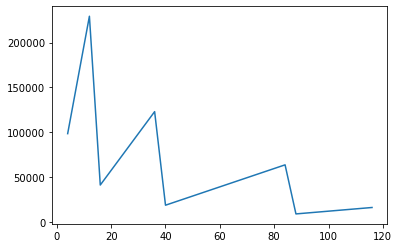

In [49]:

# for feat in info_dict['feats']:
#     y.append(feat.shape[1])

x = range(4,120,4)
y = [98304,163840,229376,40960,57344,73728,90112,106496,122880,18432,22528,26624,30720,34816,38912,43008,47104,51200,55296,59392,63488,8704,9728,10752,11776,12800,13824,14848,15872]
plt.plot(x,y)

In [48]:
y

[98304,
 163840,
 229376,
 40960,
 57344,
 73728,
 90112,
 106496,
 122880,
 18432,
 22528,
 26624,
 30720,
 34816,
 38912,
 43008,
 47104,
 51200,
 55296,
 59392,
 63488,
 8704,
 9728,
 10752,
 11776,
 12800,
 13824,
 14848,
 15872]

### run KNN to get PD

In [ ]:
# outputs a (1) array of KNN clf decision for various layers
# (2) pred depth of the image
# def compute_pred_depth(img, model, layer_embs_path, dataset='NIH'):
#     pass

def compute_pred_depth(arr):
    last = arr[-1]
    p_depth = 4
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1))*4 + 4
            break
    
    return p_depth

# plots a 
def plot_pd_distr(df, model, layer_embs_path, csv=None, dataset='NIH'):
    pass



In [ ]:
# run compute_pd.py script

### Plot PD Histograms

(array([62.]), array([-0.5,  0.5]), <BarContainer object of 1 artists>)

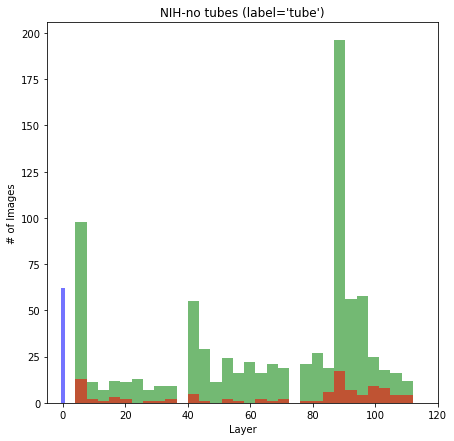

In [4]:
# plot PDs histogram
with open('/home/xxx/shortcut_detection_and_mitigation/experiments/medical_expts/nih/128/nih_test_pd.pkl', 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])
pos_pd_arr = (batch_info['pd']>=0)
batch_info['pd'][~pos_pd_arr] = 0


plt.figure(figsize=(7,7))
# plt.subplot(1,2,1)
plt.title("NIH-no tubes (label='tube')")
plt.ylabel('# of Images')
plt.xlabel('Layer')
plt.xlim((-5,120))
plt.hist(batch_info['pd'][correct_preds_arr & pos_pd_arr],bins=30,color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='r',alpha=0.55)
plt.hist(batch_info['pd'][~pos_pd_arr],bins=1,color='b',alpha=0.55)
# plt.subplot(1,2,2)
# # plt.hist(batch_info['pd'][~pos_pd_arr],bins=30,color='b',alpha=0.55)
# plt.xlim((-5,5))
# plt.bar(0,len(batch_info['pd'][~pos_pd_arr]))

In [ ]:
# plot PDs combined histogram of all groups

with open('/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_l1_pos_tube_v3.pkl', 'rb') as handle:
    batch_info1 = pickle.load(handle)
with open('/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_l1_pos_notube_v3.pkl', 'rb') as handle:
    batch_info2 = pickle.load(handle)
with open('/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_l1_neg_tube_v3.pkl', 'rb') as handle:
    batch_info3 = pickle.load(handle)
with open('/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_l1_neg_notube_v3.pkl', 'rb') as handle:
    batch_info4 = pickle.load(handle)

batch_info['pd'] = batch_info1['pd'] + batch_info2['pd'] + batch_info3['pd'] + batch_info4['pd']
batch_info['labels'] = batch_info1['labels'] + batch_info2['labels'] + batch_info3['labels'] + batch_info4['labels']
batch_info['preds'] = batch_info1['preds'] + batch_info2['preds'] + batch_info3['preds'] + batch_info4['preds']
    
batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])
pos_pd_arr = (batch_info['pd']>=0)

plt.title('Prediction Depths on Full Test Data (NIH-shortcut correlation)')
plt.ylabel('# of Images')
plt.xlabel('Layer')
# plt.ylim((0,60))
# plt.hist(batch_info['pd'][correct_preds_arr & pos_pd_arr],bins=30,color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='r',alpha=0.55)

### Plot PD across iterations

In [ ]:
for ep in range(25):
    
    start = time.time()
    
    # plot PDs histogram
    with open(f'/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_iterations/train_2k_ep{ep+1}.pkl', 'rb') as handle:
        batch_info = pickle.load(handle)

    batch_info['pd'] = np.array(batch_info['pd'])
    batch_info['labels'] = np.array(batch_info['labels'])
    batch_info['preds'] = np.array(batch_info['preds'])

    pred_cls = (batch_info['preds']>0.5).astype(int)
    correct_preds_arr = (pred_cls==batch_info['labels'])
    pos_pd_arr = (batch_info['pd']>=0)

    plt.figure(ep)
    plt.title(f'Prediction Depths (Epoch:{ep+1})')
    plt.ylabel('# of Images')
    plt.xlabel('Layer')
    plt.ylim((0,550))
    plt.hist(batch_info['pd'][correct_preds_arr & pos_pd_arr],bins=30,color='g',alpha=0.55)
    plt.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='r',alpha=0.55)
    
    end = time.time()
    print(f'Ep{ep+1} exec time: {end-start} secs')

### Analyse images belonging to certain range of PDs

In [ ]:

pred_cls = (batch_info['preds']>0.5).astype(int)

crit1 = (pred_cls==batch_info['labels'])
crit2 = (batch_info['pd']>80)
crit3 = (batch_info['pd']<100)
# crit4 = (batch_info['labels']==1) # analyse only images with pneum

img_list = np.array(batch_info['paths'])[crit1 & crit2 & crit3].tolist()
plot_images(img_list,10,3)

### KNN Predictions Across Layers for Single Test Image

In [ ]:
pkl_path = '/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut_l1_pos_notube_v3.pkl'
with open(pkl_path, 'rb') as handle:
    batch_info = pickle.load(handle)

crit1 = (np.array(batch_info['pd'])>=80)
crit2 = (np.array(batch_info['pd'])<100)
pred_cls = (np.array(batch_info['preds'])>0.5).astype(int)
crit3 = (pred_cls==batch_info['labels'])
final_arr = np.array(batch_info['layers_knn_mean'])[crit1 & crit2 & ~crit3]
# from random import random
# r_idx = int(random()*23)

for index,y in enumerate(final_arr):
    y = np.where(y==99, 0.5, y)
    x = range(0,116,4)
    plt.figure(index)
    plt.plot(x,y)
    plt.ylim((-0.1,1.1))
    plt.title('KNN Prediction Across Layers for Single Test Image')
    plt.xlabel('Layer')
    plt.ylabel('KNN Prediction')

### Run Tube Detector on PD bins of interest

100%|██████████| 88/88 [00:02<00:00, 37.12it/s]


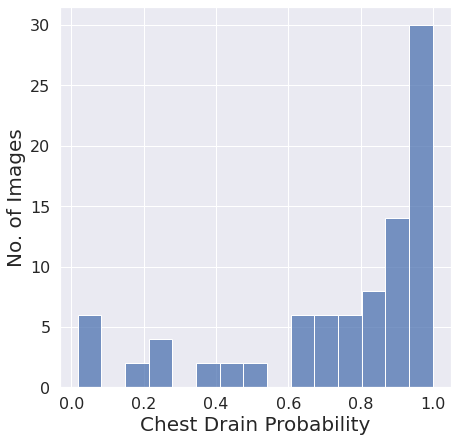

In [80]:
sns.set(style="darkgrid")

tube_detector_path = '/xxx/augmentation_by_explanation_eccv22/Output/MIMIC-CXR/tube_detector/MIMIC-CXR-densenet121-MIMIC-CXR_512-best-auc0.8580.pt'  # MIMIC tube detector
pkl_file = '/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_train_data_2k.pkl'  # pd analysis pkl file
# process pickle file
with open(pkl_file, 'rb') as handle:
    batch_info = pickle.load(handle)
    
batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['paths'] = np.array(batch_info['paths'])
pred_cls = (np.array(batch_info['preds'])>0.5).astype(int)

crit1 = (pred_cls==batch_info['labels'])
crit2 = (batch_info['pd']==40)
crit3 = (batch_info['labels']==1)

img_list = batch_info['paths'][crit3 & crit2 ].tolist()

# load model
model = torch.load(tube_detector_path).to('cuda')


# --------------------- Class Definitions ---------------------

class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)

# transforms for NIH
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(center_crop()),
    torchvision.transforms.Lambda(normalize())
])
    
# loop over chosen set of images and compute model preds
preds = []
for img_path in tqdm(img_list):
    with Image.open(img_path) as img:
        with torch.no_grad():
            img = transforms(img).unsqueeze(0).to('cuda')
            if img.shape[1]==4:
                img = img[:,0,:,:].unsqueeze(0)
            out = float(torch.sigmoid(model(img)).squeeze())
            preds.append(out)
         
plt.figure(figsize=(7,7))
fig = sns.histplot(preds,bins=15)
plt.xlabel('Chest Drain Probability',fontsize=20)
plt.ylabel('No. of Images',fontsize=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
fig.figure.savefig("/xxx/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/layer40_pos_hist.svg")

### Compute PD of a peak of interest using another classifier

In [ ]:
# create a suitable test_csv file for the peak of interest

# user hyperparams
pkl_file = '/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_spurious_iterations/age_1p0_train_2k_ep10.pkl'
pd_val = 88
save_path = '/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/temp/nih_spurious_age_pd88_red.csv'
cls_name = 'Pneumothorax'
# just verify the mask_arr is what you want

with open(pkl_file, 'rb') as handle:
    batch_info = pickle.load(handle)
    
batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
batch_info['paths'] = np.array(batch_info['paths'])

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])

df = pd.DataFrame()
mask_arr = ( (batch_info['pd']==pd_val) & ~correct_preds_arr )
df['path'] = batch_info['paths'][mask_arr]
df[cls_name] = batch_info['labels'][mask_arr]

df.to_csv(save_path,index=False)

In [ ]:
# run compute_pd.py on this

### MMD Analysis (Get Layer Embeddings)

In [ ]:
# input: densenet121 model, provide a hook function
# output: returns a model with hooks registered for all 58 layers
def register_hooks(model, hook):
    
    for idx,layer in enumerate(model.features.denseblock1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return model

feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))



In [ ]:
# user hyperparams
imgsize=128
model = torch.load('/xxxprojects/augmentation_by_explanation_eccv22/Output/NIH/imgsize_128/nih_pneum/NIH-densenet121-NIH_128-best-auc0.8326.pt').to('cuda')
model = register_hooks(model, hook_feat_map)

class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')

transforms = torchvision.transforms.Compose([
#     torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((imgsize,imgsize)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(center_crop()),
    torchvision.transforms.Lambda(normalize())
])



In [ ]:
# code for saving pkl file of layer embeddings
nih_val_csv = '/xxx/data/nih/test_split2/full_splits/pneum_neg_tube.csv'
save_path = '/xxx/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/mmd_analysis/test_split2_neg_tube/'
cls_name = 'Pneumothorax'

dataset = datasets.MIMIC_Dataset(csvpath=nih_val_csv, class_names=[cls_name], transform=transforms)
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=4096,
                                     shuffle=False,
                                     num_workers=4, 
                                     pin_memory=True)



with torch.no_grad():
    for b_idx,batch in enumerate(tqdm(loader)):
        # print GPU memory
        print_memory_profile('Initial')

        imgs = batch['img'].to('cuda')
        labels = batch['lab']
        paths = batch['file_name']

        feature_maps = []
        out = model(imgs)

        for layer_id in tqdm(range(1000)):
            if layer_id==len(feature_maps):
                break
            handle = open(os.path.join(save_path,'layer-%d.pkl' %(layer_id)), "ab")
            info_dict = {'batch_idx':b_idx,'num_batches':len(loader),'feats':feature_maps[layer_id],'labels':labels,'paths':paths}
            pickle.dump(info_dict, handle)  
            handle.close()

        # print GPU memory
        print_memory_profile('After processing Batch')

        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     

        # print GPU memory
        print_memory_profile('After freeing GPU memory')

### MMD

In [ ]:
# RUN THE COMPUTE_MMD.PY FILE TO GENERATE PICKLE FILES

In [ ]:
# plot MMD curve
neg_means = info_pos_tube['neg']['mean']
pos_means = info_pos_tube['pos']['mean']

Fig, ax = plt.subplots()
for i in range(len(pos_means)):
    pos_dist = pos_means[i]
    neg_dist = neg_means[i]
    total = pos_dist + neg_dist
    if pos_dist<neg_dist:
        color = 'g'
        norm_dist = pos_dist/total
    elif neg_dist<pos_dist:
        color = 'r'
        norm_dist = neg_dist/total
    else:
        color = 'k'
        norm_dist = 0.5

    ax.plot((i+1)*4, norm_dist, color=color,
            marker='o',
            linestyle='dashed',
            markeredgecolor=color,
            markersize=6)
    
plt.title('MMD Analysis (Neg + No Tube)')
ax.set_xlabel('Layer')
ax.set_ylabel('Min Dist')
ax.set_xlim(0,120)
ax.set_ylim(0,1)
ax.legend()

### Utility Code

In [ ]:
# creating new columns by binarizing already present columns
df['gender_m0f1'] = df['gender']
df['age_geq_50'] = df['age_in_years']
df['view_pa0_ap1'] = df['view']
df['gender_m0f1'] = df['gender_m0f1'].replace({'M':0,'F':1})
df['view_pa0_ap1'] = df['view_pa0_ap1'].replace({'PA':0,'AP':1})
df['age_geq_50'] = df['age_geq_50'].apply(lambda x: 1 if x>=50 else 0)

### Misc

In [23]:
for i in [0,1]:
    for j in [0,1]:
        for k in [0,1]:
            arr1= ((df['view_pa0_ap1']==i)&(df['age_geq_50']==j)&(df['Pneumothorax']==k))
            print(len(df[arr1]))

29695
1560
28565
1537
20303
945
18751
764


In [43]:
arr1= ((df['view_pa0_ap1']==1)&(df['age_geq_50']==1)&(df['Pneumothorax']==1))
len(df[arr1])

764